# Label Shuffle Experiment

The progressive learning package utilizes representation ensembling algorithms to sequentially learn a representation for each task and ensemble both old and new representations for all future decisions. 

Here, a representation ensembling algorithm based on decision forests (Omnidirectional Forest) demonstrate forward and backward knowledge transfer of tasks on the CIFAR100 dataset with the labels shuffled. The experiment reproduces the benchmarking adversarial experiment ran in the paper "Omnidirectional Transfer for Quasilinear Lifelong Learning" by Vogelstein, et al (2020). The following is a link to the aforementioned paper: https://arxiv.org/pdf/2004.12908.pdf  

### Import necessary packages and modules

In [1]:
import numpy as np
import keras
from joblib import Parallel, delayed
from itertools import product

Using TensorFlow backend.


### Load CIFAR100 data 
We load the CIFAR100 dataset from Keras, and store it in a variable. The training and test partitions are concatenated into one variable called `data_x`. The data is obtained from https://keras.io/api/datasets/cifar100/ .

The label shuffle experiment randomly permutes the class labels within each task from task 2 to 10, rendering each of these tasks adversarial with regard to the first task. We show through this experiment that L2F are invariant to class lable shuffling, and both demonstrate transfer.  

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()
data_x = np.concatenate([X_train, X_test])

### Define hyperparameters for the model and preprocess data
Running the cells below will define the hyperparameters the experimental setting 

`num_points_per_task`: The number of points per task 

`shifts`: The number of data ways to split the data into train and test

In [3]:
num_points_per_task = 500

shifts = 2 

num_slots = int(5000 // num_points_per_task)
slot_fold = range(int(5000 // num_points_per_task))

This cell will preprocess the data

In [4]:
# Reshape the data 
data_x = data_x.reshape((data_x.shape[0], data_x.shape[1] * data_x.shape[2] * data_x.shape[3]))
data_y = np.concatenate([y_train, y_test])
data_y = data_y[:, 0]

### Train the model and perform validation

#### run_parallel_exp: 
Wrapper method for the `label_shuffle_experiment` function which declares and trains the model, and performs validation with respect to the test data to compute the error of the model at a particular iteration

`ntree`: Number of trees for Uncertainty Forest

In [5]:
from functions.label_shuffle_functions import run_parallel_exp

n_trees=[10] # Number of trees in UF

shift_fold = range(1,shifts,1) # Number of shifts
iterable = product(n_trees,shift_fold,slot_fold)

df_list = Parallel(n_jobs=-1,verbose=0)(
    delayed(run_parallel_exp)(
            data_x, data_y, ntree, num_points_per_task, slot=slot, shift=shift
            ) for ntree,shift,slot in iterable
            )

### Function to calculate backward transfer efficiency

The backward transfer efficiency of $f_n$ for task $t$ given $n$ samples is 
$$BTE^t (f_n) := \mathbb{E} [R^t (f_n^{<t} )/R^t (f_n)]$$

We say an algorithm achieves backward transfer for task $t$ if and only if $BTE^t(f_n) > 1$. Intuitively, this means that the progressive learner has used data associated with new tasks to improve performance on previous tasks. 

#### calc_bte:
Function used to calculate bte across tasks, averaged across all shifts and folds

In [6]:
from functions.label_shuffle_functions import calc_bte

btes = calc_bte(df_list, num_slots, shifts)

### Plotting the backward transfer efficiency
Run cell to generate plot of backward transfer efficiency of the Omnidirectional Classification Forest algorithm. We see that we achieve backwards transfer overall that increases as more tasks are seen.

#### plot_bte:
Function used to plot bte across tasks

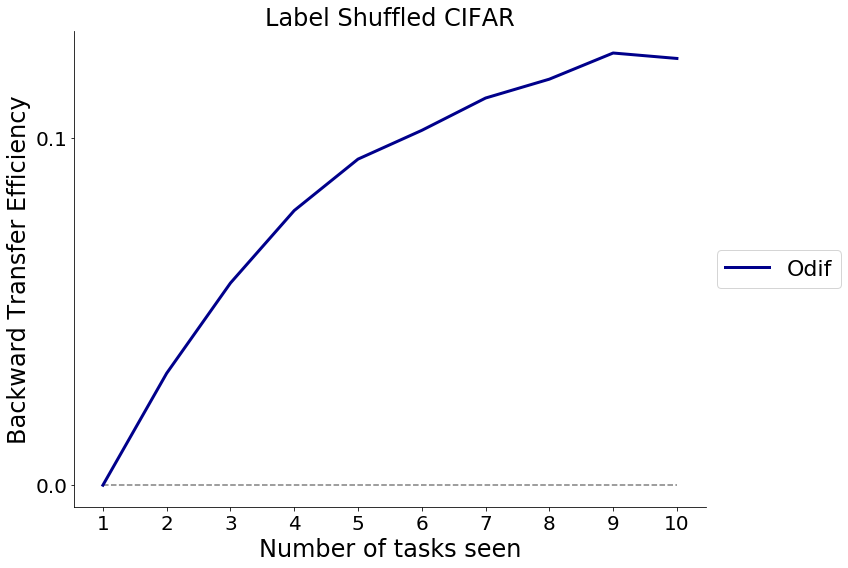

In [7]:
from functions.label_shuffle_functions import plot_bte

plot_bte(btes)